In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

drive.mount('/content/drive')
sales_data = pd.DataFrame(pd.read_excel('/content/drive/MyDrive/Colab Notebooks/vkrdata.xlsx'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


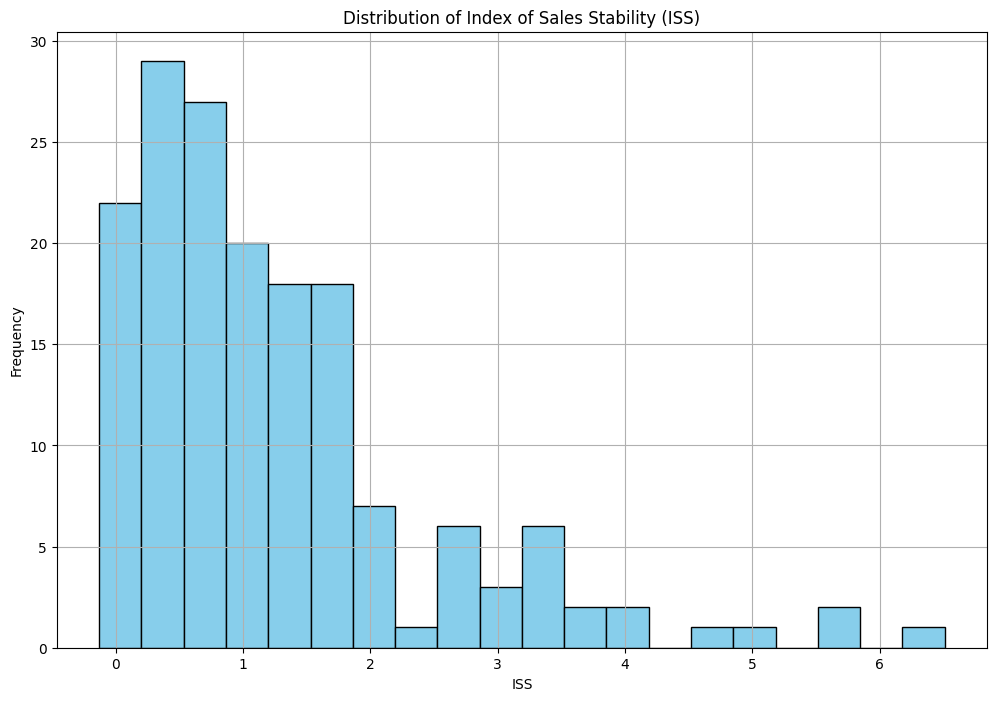

Stability
Low       90
Medium    47
High      29
Name: count, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Drop columns not related to sales
sales_data = sales_data.drop(columns=['Client Banner', 'SO Region RUS'])

# Sum sales data by SKU across all regions and stores
sales_data_grouped = sales_data.groupby('Product Name').sum()

# Fill missing values with the median value of each SKU
sales_data_grouped = sales_data_grouped.apply(lambda x: x.fillna(x.median()), axis=0)

# Calculate the mean and standard deviation for each SKU
mean_sales = sales_data_grouped.mean(axis=1)
std_sales = sales_data_grouped.std(axis=1)

# Calculate the Index of Sales Stability (ISS) for each SKU
iss = mean_sales / std_sales

# Add the ISS to the grouped sales data
sales_data_grouped['ISS'] = iss

# Classify SKU based on ISS
sales_data_grouped['Stability'] = pd.cut(sales_data_grouped['ISS'], bins=[-np.inf, 1, 2, np.inf], labels=['Low', 'Medium', 'High'])

# Plotting the ISS
plt.figure(figsize=(12, 8))
plt.hist(sales_data_grouped['ISS'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Index of Sales Stability (ISS)')
plt.xlabel('ISS')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Display the summary of the classification
classification_summary = sales_data_grouped['Stability'].value_counts()
classification_summary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


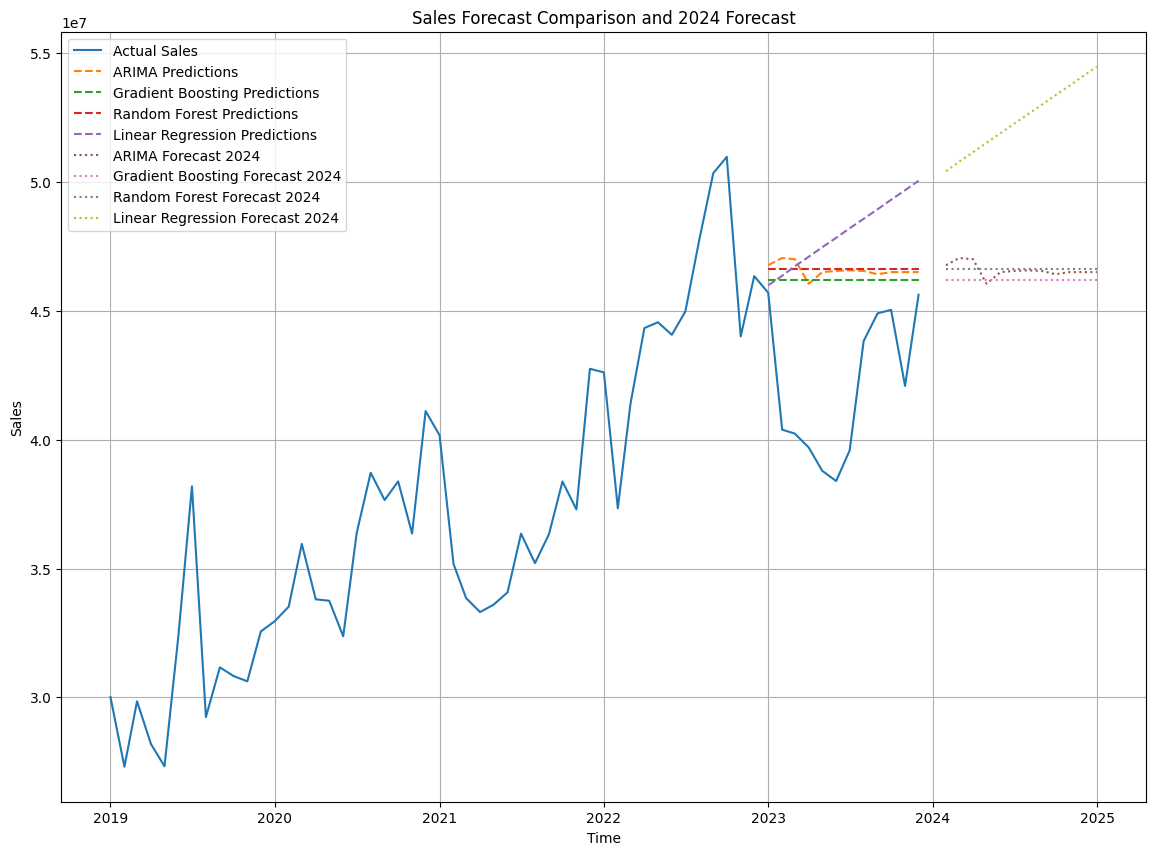

,Model,MSE,R²
0,ARIMA,2.821771e+13,-2.849049
1,Gradient Boosting,2.491716e+13,-2.398836
2,Random Forest,2.858833e+13,-2.899604
3,Linear Regression,4.214600e+13,-4.748944


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Функция для оценки моделей
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, r2
# Суммирование данных о продажах по SKU во всех регионах и магазинах
sales_data_grouped = sales_data.groupby('Product Name').sum()

# Заполнение пропущенных значений медианным значением каждого SKU
sales_data_grouped = sales_data_grouped.apply(lambda x: x.fillna(x.median()), axis=0)

# Вычисление среднего значения и стандартного отклонения для каждого SKU
mean_sales = sales_data_grouped.mean(axis=1)
std_sales = sales_data_grouped.std(axis=1)

# Вычисление Индекса Устойчивости Продаж (ИУП) для каждого SKU
iss = mean_sales / std_sales

# Добавление ИУП к сгруппированным данным о продажах
sales_data_grouped['ISS'] = iss

# Выбор SKU с высокой устойчивостью продаж
high_stability_sku = sales_data_grouped.sort_values(by='ISS', ascending=False).iloc[0].name
sku_sales = sales_data_grouped.loc[high_stability_sku].drop(['ISS'])

# Преобразование индекса временных рядов в формат datetime
sku_sales.index = pd.to_datetime(sku_sales.index, format='%Y_%m')

# Подготовка данных для прогнозирования
train_size = int(len(sku_sales) * 0.8)
train, test = sku_sales[:train_size], sku_sales[train_size:]

# Метод 1: ARIMA
model_arima = ARIMA(train, order=(5, 1, 0))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.forecast(steps=len(test))
forecast_arima = model_arima_fit.forecast(steps=12)

# Метод 2: Gradient Boosting
X_train = np.arange(len(train)).reshape(-1, 1)
y_train = train.values
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
X_forecast = np.arange(len(train) + len(test), len(train) + len(test) + 12).reshape(-1, 1)

model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
predictions_gb = model_gb.predict(X_test)
forecast_gb = model_gb.predict(X_forecast)

# Метод 3: Random Forest
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
forecast_rf = model_rf.predict(X_forecast)

# Метод 4: Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_lr = model_lr.predict(X_test)
forecast_lr = model_lr.predict(X_forecast)

# Оценка моделей на тестовом наборе данных
mse_arima, r2_arima = evaluate_model(test, predictions_arima)
mse_gb, r2_gb = evaluate_model(test, predictions_gb)
mse_rf, r2_rf = evaluate_model(test, predictions_rf)
mse_lr, r2_lr = evaluate_model(test, predictions_lr)

# Отображение результатов
results = pd.DataFrame({
    'Model': ['ARIMA', 'Gradient Boosting', 'Random Forest', 'Linear Regression'],
    'MSE': [mse_arima, mse_gb, mse_rf, mse_lr],
    'R²': [r2_arima, r2_gb, r2_rf, r2_lr]
})

# Построение графиков прогнозов и фактических данных
plt.figure(figsize=(14, 10))
plt.plot(sku_sales.index, sku_sales, label='Actual Sales')
plt.plot(test.index, predictions_arima, label='ARIMA Predictions', linestyle='--')
plt.plot(test.index, predictions_gb, label='Gradient Boosting Predictions', linestyle='--')
plt.plot(test.index, predictions_rf, label='Random Forest Predictions', linestyle='--')
plt.plot(test.index, predictions_lr, label='Linear Regression Predictions', linestyle='--')

# Построение прогноза на 2024 год
future_dates = pd.date_range(start=sku_sales.index[-1], periods=13, freq='M')[1:]
plt.plot(future_dates, forecast_arima, label='ARIMA Forecast 2024', linestyle=':')
plt.plot(future_dates, forecast_gb, label='Gradient Boosting Forecast 2024', linestyle=':')
plt.plot(future_dates, forecast_rf, label='Random Forest Forecast 2024', linestyle=':')
plt.plot(future_dates, forecast_lr, label='Linear Regression Forecast 2024', linestyle=':')

plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Sales Forecast Comparison and 2024 Forecast')
plt.legend()
plt.grid(True)
plt.show()

results


In [ ]:
drive.mount('/content/drive')
sales_data = pd.DataFrame(pd.read_excel('/content/drive/MyDrive/Colab Notebooks/vkrdata.xlsx'))
import pandas as pd

# Показ первых нескольких строк таблицы для ознакомления со структурой данных
sales_data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Client Banner,SO Region RUS,Product Name,2019_01,2019_02,2019_03,2019_04,2019_05,2019_06,2019_07,...,2023_03,2023_04,2023_05,2023_06,2023_07,2023_08,2023_09,2023_10,2023_11,2023_12
0,Client 1,Region 1,Product 1,202515.6672,300960.7832,419094.9224,464098.404,835377.1272,691928.5296,531603.6264,...,2858850.060,3869630.82,4292046.660,3496245.390,2817362.79,3696138.60,4480625.160,5289136.875,4952908.125,6082291.875
1,Client 1,Region 1,Product 2,12414.9025,7452.2690,NaN,10285.363,102668.8630,259536.0460,301170.2100,...,702900.495,591256.82,792821.645,998730.975,1087136.60,1060261.29,1000145.465,1121321.520,1023560.175,880848.540
2,Client 1,Region 1,Product 3,231205.5900,222030.7650,281157.4150,363730.840,279526.3350,289108.9300,282176.8400,...,860594.350,839546.40,1014451.900,952197.400,883421.00,968798.60,900911.550,1036292.400,1104382.125,1229268.645
3,Client 1,Region 1,Product 4,175544.9850,166370.1600,221215.2250,290943.895,223457.9600,231613.3600,225292.9250,...,625805.950,558215.35,636478.150,623137.900,579263.30,640924.90,629363.350,688204.440,752640.570,872212.770
4,Client 1,Region 1,Product 5,115195.0250,104185.2350,146389.4300,196137.370,235487.1750,229574.5100,143535.0400,...,465130.050,430741.85,452382.700,424812.850,440228.25,513451.40,483509.950,477292.365,426142.035,457363.665


In [ ]:
# Проверка названий колонок в датафрейме
sales_data.columns

Index(['Client Banner', 'SO Region RUS', 'Product Name', '2019_01', '2019_02',
       '2019_03', '2019_04', '2019_05', '2019_06', '2019_07', '2019_08',
       '2019_09', '2019_10', '2019_11', '2019_12', '2020_01', '2020_02',
       '2020_03', '2020_04', '2020_05', '2020_06', '2020_07', '2020_08',
       '2020_09', '2020_10', '2020_11', '2020_12', '2021_01', '2021_02',
       '2021_03', '2021_04', '2021_05', '2021_06', '2021_07', '2021_08',
       '2021_09', '2021_10', '2021_11', '2021_12', '2022_01', '2022_02',
       '2022_03', '2022_04', '2022_05', '2022_06', '2022_07', '2022_08',
       '2022_09', '2022_10', '2022_11', '2022_12', '2023_01', '2023_02',
       '2023_03', '2023_04', '2023_05', '2023_06', '2023_07', '2023_08',
       '2023_09', '2023_10', '2023_11', '2023_12'],
      dtype='object')

In [ ]:
# Корректируем выборку данных с правильным названием колонки
product_1_data = sales_data[(sales_data['Product Name'] == 'Product 1') & (sales_data['SO Region RUS'] == 'Region 1')]

# Извлекаем данные о продажах за ноябрь и декабрь 2023 года
november_sales = product_1_data['2023_11'].values[0]
december_sales = product_1_data['2023_12'].values[0]

# Расчет темпа роста продаж
growth_rate = (december_sales / november_sales - 1) * 100

november_sales, december_sales, growth_rate


(4952908.125, 6082291.875000001, 22.80243690165362)

In [ ]:
# Суммируем выручку за все месяцы 2019 и 2023 годов для каждого продукта
sales_data['Total 2019'] = sales_data[[f'2019_{str(month).zfill(2)}' for month in range(1, 13)]].sum(axis=1)
sales_data['Total 2023'] = sales_data[[f'2023_{str(month).zfill(2)}' for month in range(1, 13)]].sum(axis=1)

# Рассчитываем процентное изменение выручки с 2019 по 2023 год
sales_data['Growth Rate (%)'] = ((sales_data['Total 2023'] - sales_data['Total 2019']) / sales_data['Total 2019']) * 100

# Топ 5 продуктов с наибольшим увеличением и уменьшением выручки
top_5_best_products = sales_data.nlargest(5, 'Growth Rate (%)')[['Product Name', 'Total 2019', 'Total 2023', 'Growth Rate (%)']]
top_5_worst_products = sales_data.nsmallest(5, 'Growth Rate (%)')[['Product Name', 'Total 2019', 'Total 2023', 'Growth Rate (%)']]

top_5_best_products, top_5_worst_products


(   Product Name  Total 2019   Total 2023  Growth Rate (%)
 8     Product 9         0.0       94.380              inf
 9    Product 10         0.0     1510.080              inf
 10   Product 11         0.0     1698.840              inf
 11   Product 12         0.0  5748664.625              inf
 13   Product 14         0.0  4781827.435              inf,
     Product Name  Total 2019  Total 2023  Growth Rate (%)
 156    Product 9         0.0      -94.38             -inf
 157   Product 10         0.0     -171.82             -inf
 438    Product 9         0.0     -660.66             -inf
 440   Product 11         0.0     -266.20             -inf
 535  Product 153         0.0     -373.78             -inf)

In [ ]:
# Суммируем выручку за все месяцы 2022 и 2023 годов для каждого продукта
sales_data['Total 2022'] = sales_data[[f'2022_{str(month).zfill(2)}' for month in range(1, 13)]].sum(axis=1)
sales_data['Total 2023'] = sales_data[[f'2023_{str(month).zfill(2)}' for month in range(1, 13)]].sum(axis=1)

# Исключаем продукты с нулевой выручкой в любой из этих двух лет
filtered_data = sales_data[(sales_data['Total 2022'] > 0) & (sales_data['Total 2023'] > 0)]

# Рассчитываем процентное изменение выручки с 2022 по 2023 год
filtered_data['Growth Rate (%)'] = ((filtered_data['Total 2023'] - filtered_data['Total 2022']) / filtered_data['Total 2022']) * 100

# Топ 5 продуктов с наибольшим увеличением и уменьшением выручки
top_5_best_products_2022_2023 = filtered_data.nlargest(5, 'Growth Rate (%)')[['Product Name', 'Total 2022', 'Total 2023', 'Growth Rate (%)']]
top_5_worst_products_2022_2023 = filtered_data.nsmallest(5, 'Growth Rate (%)')[['Product Name', 'Total 2022', 'Total 2023', 'Growth Rate (%)']]

top_5_best_products_2022_2023, top_5_worst_products_2022_2023


<ipython-input-22-00c8abbf2567>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Growth Rate (%)'] = ((filtered_data['Total 2023'] - filtered_data['Total 2022']) / filtered_data['Total 2022']) * 100


(     Product Name  Total 2022   Total 2023  Growth Rate (%)
 961    Product 27     4954.95   930246.185     18674.078144
 1332   Product 29    18828.81  2997157.295     15817.932652
 1141   Product 27     9909.90  1444445.970     14475.787546
 868    Product 29     8918.91  1287833.855     14339.363723
 1782  Product 125     1416.91   168003.660     11757.045260,
     Product Name    Total 2022  Total 2023  Growth Rate (%)
 674  Product 110  2.157387e+07    4595.580       -99.978698
 319   Product 30  4.733296e+06    1170.675       -99.975267
 251  Product 110  1.200548e+07    3446.685       -99.971291
 668  Product 104  2.324424e+07    8182.020       -99.964800
 819  Product 114  4.128297e+07   25475.945       -99.938289)

In [ ]:
# Группировка данных по клиентам и подсчет суммарной выручки за 2022 и 2023 годы
client_sales_2022 = sales_data.groupby('Client Banner')['Total 2022'].sum()
client_sales_2023 = sales_data.groupby('Client Banner')['Total 2023'].sum()

# Объединение данных по клиентам в один DataFrame
client_growth = pd.DataFrame({
    'Sales 2022': client_sales_2022,
    'Sales 2023': client_sales_2023
})
client_growth['Growth Rate (%)'] = ((client_growth['Sales 2023'] - client_growth['Sales 2022']) / client_growth['Sales 2022']) * 100

# Отбор топ 5 клиентов по росту и падению выручки
top_5_clients_growth = client_growth.nlargest(5, 'Growth Rate (%)')
top_5_clients_decline = client_growth.nsmallest(5, 'Growth Rate (%)')

top_5_clients_growth, top_5_clients_decline

(                 Sales 2022    Sales 2023  Growth Rate (%)
 Client Banner                                             
 Client 1       4.816453e+09  6.116709e+09        26.996128
 Client 3       1.429967e+09  1.498071e+09         4.762613
 Client 2       2.028187e+09  1.823169e+09       -10.108394,
                  Sales 2022    Sales 2023  Growth Rate (%)
 Client Banner                                             
 Client 2       2.028187e+09  1.823169e+09       -10.108394
 Client 3       1.429967e+09  1.498071e+09         4.762613
 Client 1       4.816453e+09  6.116709e+09        26.996128)

In [ ]:
# Группировка данных по регионам и подсчет суммарной выручки за 2022 и 2023 годы
region_sales_2022 = sales_data.groupby('SO Region RUS')['Total 2022'].sum()
region_sales_2023 = sales_data.groupby('SO Region RUS')['Total 2023'].sum()

# Объединение данных по регионам в один DataFrame
region_growth = pd.DataFrame({
    'Sales 2022': region_sales_2022,
    'Sales 2023': region_sales_2023
})
region_growth['Growth Rate (%)'] = ((region_growth['Sales 2023'] - region_growth['Sales 2022']) / region_growth['Sales 2022']) * 100

# Отбор топ 5 регионов по росту и падению выручки
top_5_regions_growth = region_growth.nlargest(5, 'Growth Rate (%)')
top_5_regions_decline = region_growth.nsmallest(5, 'Growth Rate (%)')

top_5_regions_growth, top_5_regions_decline


(                 Sales 2022    Sales 2023  Growth Rate (%)
 SO Region RUS                                             
 Region 1       1.734227e+09  2.138341e+09        23.302213
 Region 3       1.249818e+09  1.488465e+09        19.094544
 Region 6       1.998250e+09  2.239676e+09        12.081875
 Region 4       1.010853e+09  1.117491e+09        10.549281
 Region 2       8.503180e+08  9.285696e+08         9.202637,
                  Sales 2022    Sales 2023  Growth Rate (%)
 SO Region RUS                                             
 Region 5       1.431141e+09  1.525407e+09         6.586828
 Region 2       8.503180e+08  9.285696e+08         9.202637
 Region 4       1.010853e+09  1.117491e+09        10.549281
 Region 6       1.998250e+09  2.239676e+09        12.081875
 Region 3       1.249818e+09  1.488465e+09        19.094544)

In [ ]:
# Расчет общей выручки каждого продукта за 2023 год и сортировка по убыванию
total_sales_per_product_2023 = sales_data.groupby('Product Name')['Total 2023'].sum().sort_values(ascending=False)

# Расчет кумулятивного процента от общей выручки
cumulative_percentage = total_sales_per_product_2023.cumsum() / total_sales_per_product_2023.sum() * 100

# Классификация продуктов в категории A, B, C
product_categories = pd.cut(cumulative_percentage, bins=[0, 80, 95, 100], labels=['A', 'B', 'C'], right=True)

# Создание итоговой таблицы с категориями
abc_analysis_results = pd.DataFrame({
    'Total Sales 2023': total_sales_per_product_2023,
    'Cumulative Percentage (%)': cumulative_percentage,
    'Category': product_categories
})

# Вывод первых нескольких строк таблицы для проверки
abc_analysis_results.head(10)


,Total Sales 2023,Cumulative Percentage (%),Category
Product Name,,,
Product 103,6.181124e+08,6.549223,A
Product 109,6.130076e+08,13.044359,A
Product 53,5.950105e+08,19.348806,A
Product 105,5.539302e+08,25.217986,A
Product 136,5.372985e+08,30.910944,A
Product 140,5.324631e+08,36.552669,A
Product 47,5.043030e+08,41.896022,A
Product 98,4.515730e+08,46.680674,A
Product 142,3.615840e+08,50.511845,A


In [ ]:
# Определение топ-5 продуктов для каждой категории и подсчет общего количества продуктов и выручки по категориям
top_5_per_category = abc_analysis_results.groupby('Category').head(5)
totals_per_category = abc_analysis_results.groupby('Category').agg(Total_Count=('Total Sales 2023', 'count'), Total_Sales=('Total Sales 2023', 'sum'))

# Объединение результатов в одну таблицу
abc_summary = pd.concat([top_5_per_category, totals_per_category])

abc_summary


,Total Sales 2023,Cumulative Percentage (%),Category,Total_Count,Total_Sales
Product 103,6.181124e+08,6.549223,A,NaN,NaN
Product 109,6.130076e+08,13.044359,A,NaN,NaN
Product 53,5.950105e+08,19.348806,A,NaN,NaN
Product 105,5.539302e+08,25.217986,A,NaN,NaN
Product 136,5.372985e+08,30.910944,A,NaN,NaN
Product 1,1.045245e+08,80.541054,B,NaN,NaN
Product 97,9.527963e+07,81.550592,B,NaN,NaN
Product 128,9.021696e+07,82.506488,B,NaN,NaN
Product 126,8.924573e+07,83.452093,B,NaN,NaN
Product 141,8.567456e+07,84.359859,B,NaN,NaN


In [ ]:
# Определение топ-5 продуктов для каждой категории и подсчет общего количества продуктов и выручки по категориям
top_5_per_category = abc_analysis_results.groupby('Category').head(5)
totals_per_category = abc_analysis_results.groupby('Category').agg(Total_Count=('Total Sales 2023', 'count'), Total_Sales=('Total Sales 2023', 'sum'))

# Объединение результатов в одну таблицу
abc_summary = pd.concat([top_5_per_category, totals_per_category])

abc_summary


,Total Sales 2023,Cumulative Percentage (%),Category,Total_Count,Total_Sales
Product 103,6.181124e+08,6.549223,A,NaN,NaN
Product 109,6.130076e+08,13.044359,A,NaN,NaN
Product 53,5.950105e+08,19.348806,A,NaN,NaN
Product 105,5.539302e+08,25.217986,A,NaN,NaN
Product 136,5.372985e+08,30.910944,A,NaN,NaN
Product 1,1.045245e+08,80.541054,B,NaN,NaN
Product 97,9.527963e+07,81.550592,B,NaN,NaN
Product 128,9.021696e+07,82.506488,B,NaN,NaN
Product 126,8.924573e+07,83.452093,B,NaN,NaN
Product 141,8.567456e+07,84.359859,B,NaN,NaN


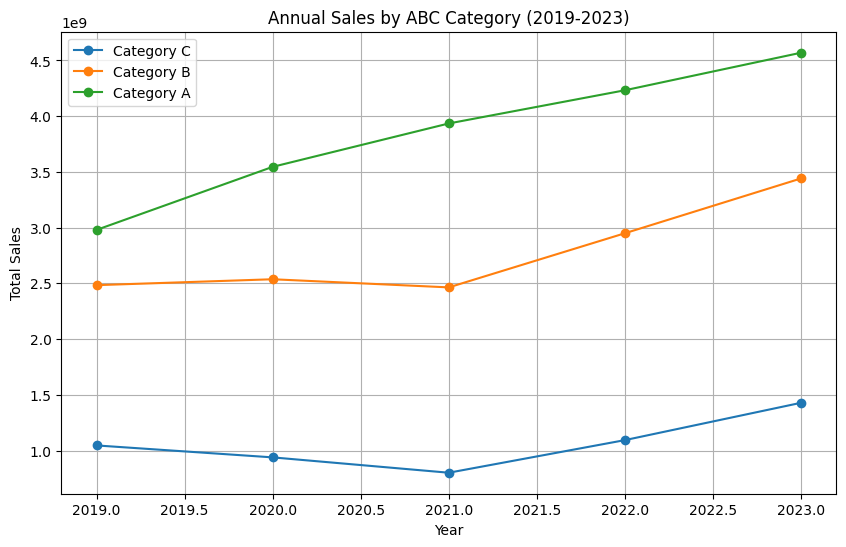

In [ ]:
import matplotlib.pyplot as plt

# Создаем DataFrame для анализа продаж по годам и категориям ABC
years_columns = [f"{year}_{str(month).zfill(2)}" for year in range(2019, 2024) for month in range(1, 13)]
sales_data['Total Sales'] = sales_data[years_columns].sum(axis=1)
sales_data['ABC Category'] = pd.cut(sales_data['Total Sales'], bins=[0, sales_data['Total Sales'].quantile(0.8),
                                                                     sales_data['Total Sales'].quantile(0.95),
                                                                     sales_data['Total Sales'].max()],
                                     labels=['C', 'B', 'A'], include_lowest=True)

# Группирование данных по категориям и годам для визуализации
abc_sales_by_year = sales_data.groupby(['ABC Category'])[years_columns].sum().T
abc_sales_by_year.index = pd.to_datetime(abc_sales_by_year.index, format='%Y_%m')
abc_sales_by_year = abc_sales_by_year.resample('Y').sum()

# Построение графика
plt.figure(figsize=(10, 6))
for category in abc_sales_by_year.columns:
    plt.plot(abc_sales_by_year.index.year, abc_sales_by_year[category], marker='o', label=f'Category {category}')
plt.title('Annual Sales by ABC Category (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


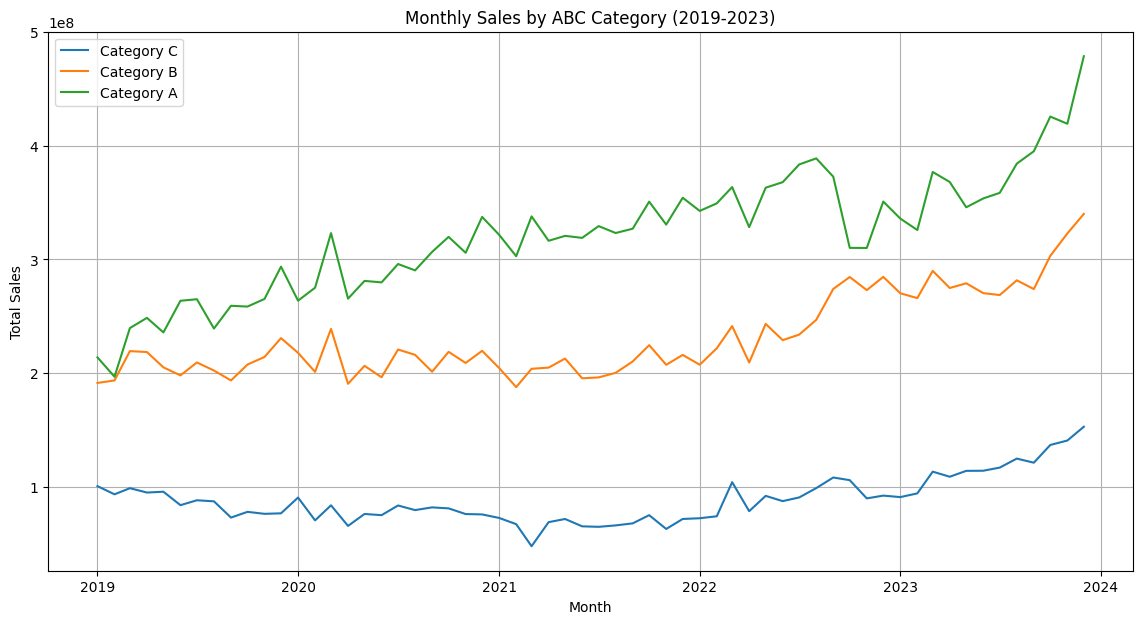

In [ ]:
# Группирование данных по категориям и месяцам для визуализации
abc_monthly_sales = sales_data.groupby(['ABC Category'])[years_columns].sum().T
abc_monthly_sales.index = pd.to_datetime(abc_monthly_sales.index, format='%Y_%m')

# Построение графиков временных рядов для каждой категории ABC
plt.figure(figsize=(14, 7))
for category in abc_monthly_sales.columns:
    plt.plot(abc_monthly_sales.index, abc_monthly_sales[category], label=f'Category {category}')
plt.title('Monthly Sales by ABC Category (2019-2023)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


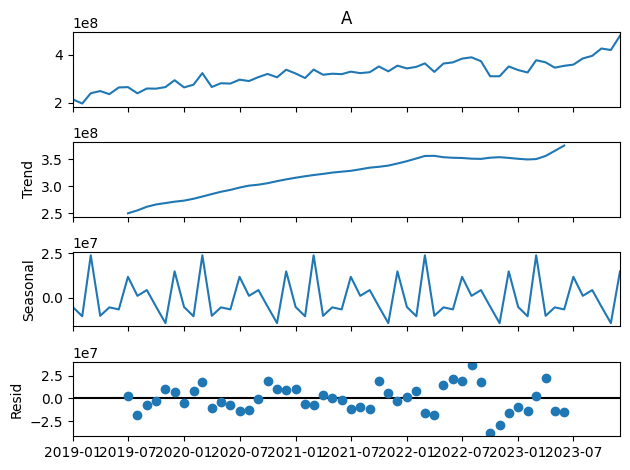

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zer

2024-01-01    4.757685e+08
2024-02-01    4.690146e+08
2024-03-01    5.085509e+08
2024-04-01    4.926609e+08
2024-05-01    4.865015e+08
2024-06-01    4.928646e+08
2024-07-01    5.001245e+08
2024-08-01    5.116799e+08
2024-09-01    5.183225e+08
2024-10-01    5.294097e+08
2024-11-01    5.232737e+08
2024-12-01    5.682011e+08
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Декомпозиция временного ряда для категории A для анализа компонент
decompose_result_A = seasonal_decompose(abc_monthly_sales['A'], model='additive', period=12)
decompose_result_A.plot()
plt.show()

# Настройка и тренировка ARIMA модели для категории A
# Используем простую конфигурацию модели, для демонстрации
arima_model_A = ARIMA(abc_monthly_sales['A'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arima_result_A = arima_model_A.fit()

# Прогноз на следующий год (12 месяцев)
forecast_A = arima_result_A.forecast(steps=12)

forecast_A


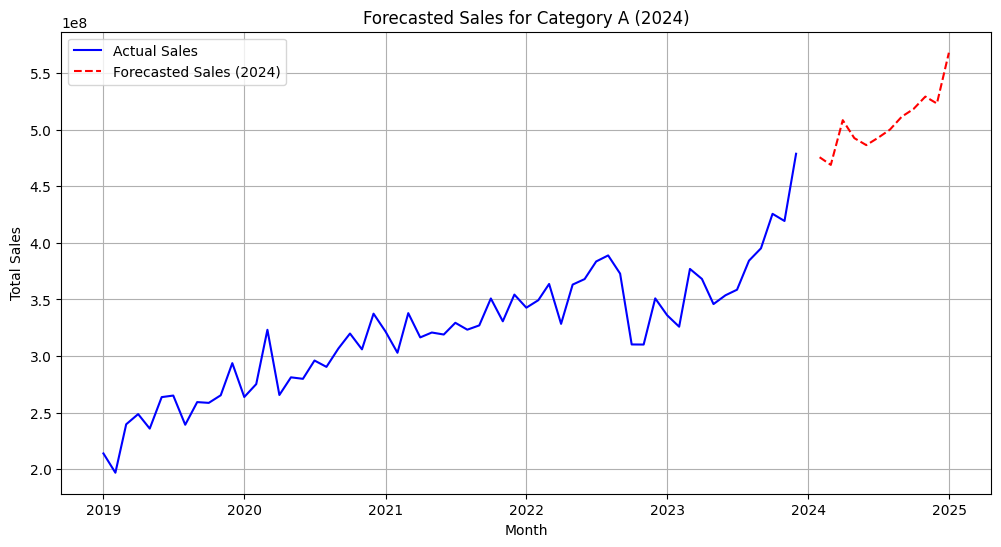

In [ ]:
# Построение графика прогноза продаж для категории A на 2024 год
plt.figure(figsize=(12, 6))

# Оригинальные данные
plt.plot(abc_monthly_sales.index, abc_monthly_sales['A'], label='Actual Sales', color='blue')

# Прогноз
forecast_dates_A = pd.date_range(start=abc_monthly_sales.index[-1], periods=13, freq='M')[1:]
plt.plot(forecast_dates_A, forecast_A, label='Forecasted Sales (2024)', color='red', linestyle='--')

plt.title('Forecasted Sales for Category A (2024)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


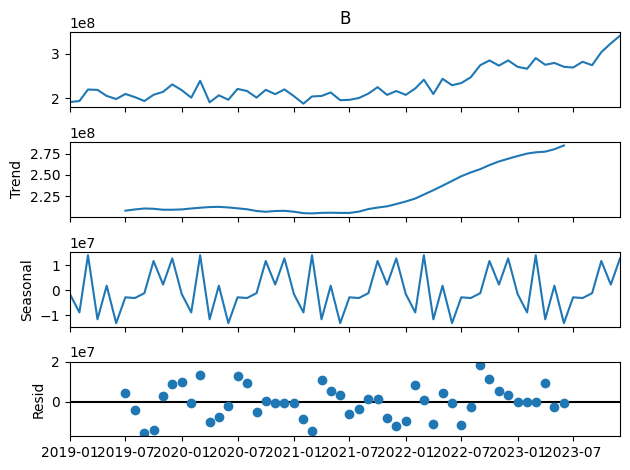

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as 

2024-01-01    3.388882e+08
2024-02-01    3.346887e+08
2024-03-01    3.555946e+08
2024-04-01    3.409604e+08
2024-05-01    3.460572e+08
2024-06-01    3.375382e+08
2024-07-01    3.387948e+08
2024-08-01    3.475481e+08
2024-09-01    3.434359e+08
2024-10-01    3.657904e+08
2024-11-01    3.769421e+08
2024-12-01    3.911895e+08
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
# Декомпозиция временного ряда для категории B для анализа компонент
decompose_result_B = seasonal_decompose(abc_monthly_sales['B'], model='additive', period=12)
decompose_result_B.plot()
plt.show()

# Настройка и тренировка ARIMA модели для категории B
arima_model_B = ARIMA(abc_monthly_sales['B'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arima_result_B = arima_model_B.fit()

# Прогноз на следующий год (12 месяцев) для категории B
forecast_B = arima_result_B.forecast(steps=12)

forecast_B


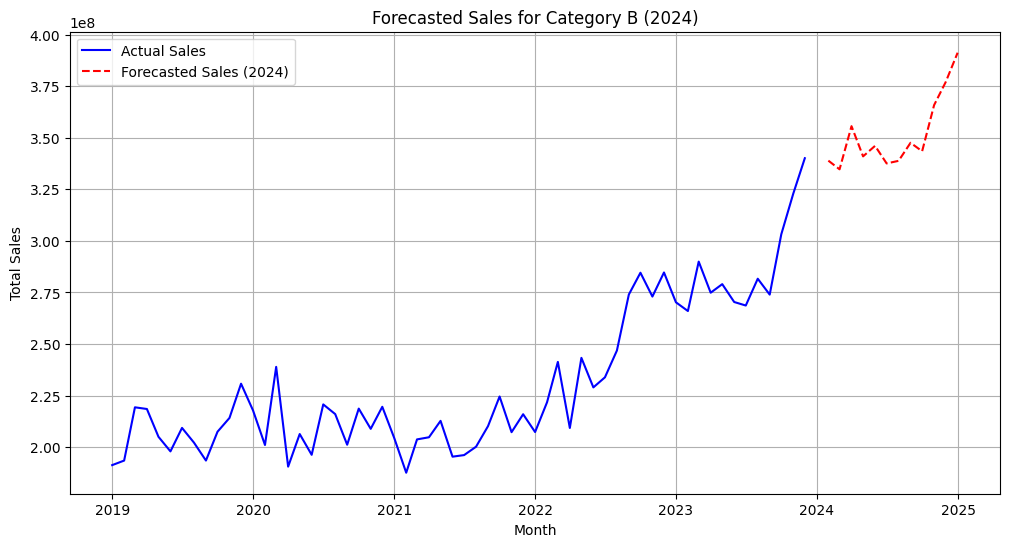

In [ ]:
# Построение графика прогноза продаж для категории B на 2024 год
plt.figure(figsize=(12, 6))

# Оригинальные данные
plt.plot(abc_monthly_sales.index, abc_monthly_sales['B'], label='Actual Sales', color='blue')

# Прогноз
forecast_dates_B = pd.date_range(start=abc_monthly_sales.index[-1], periods=13, freq='M')[1:]
plt.plot(forecast_dates_B, forecast_B, label='Forecasted Sales (2024)', color='red', linestyle='--')

plt.title('Forecasted Sales for Category B (2024)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


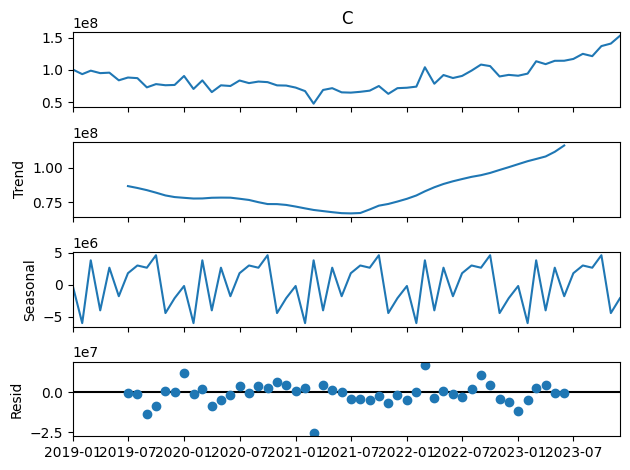

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


2024-01-01    1.601289e+08
2024-02-01    1.592983e+08
2024-03-01    1.718769e+08
2024-04-01    1.666483e+08
2024-05-01    1.723017e+08
2024-06-01    1.699296e+08
2024-07-01    1.727911e+08
2024-08-01    1.773801e+08
2024-09-01    1.761840e+08
2024-10-01    1.845032e+08
2024-11-01    1.819034e+08
2024-12-01    1.897535e+08
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
# Декомпозиция временного ряда для категории C для анализа компонент
decompose_result_C = seasonal_decompose(abc_monthly_sales['C'], model='additive', period=12)
decompose_result_C.plot()
plt.show()

# Настройка и тренировка ARIMA модели для категории C
arima_model_C = ARIMA(abc_monthly_sales['C'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
arima_result_C = arima_model_C.fit()

# Прогноз на следующий год (12 месяцев) для категории C
forecast_C = arima_result_C.forecast(steps=12)

forecast_C


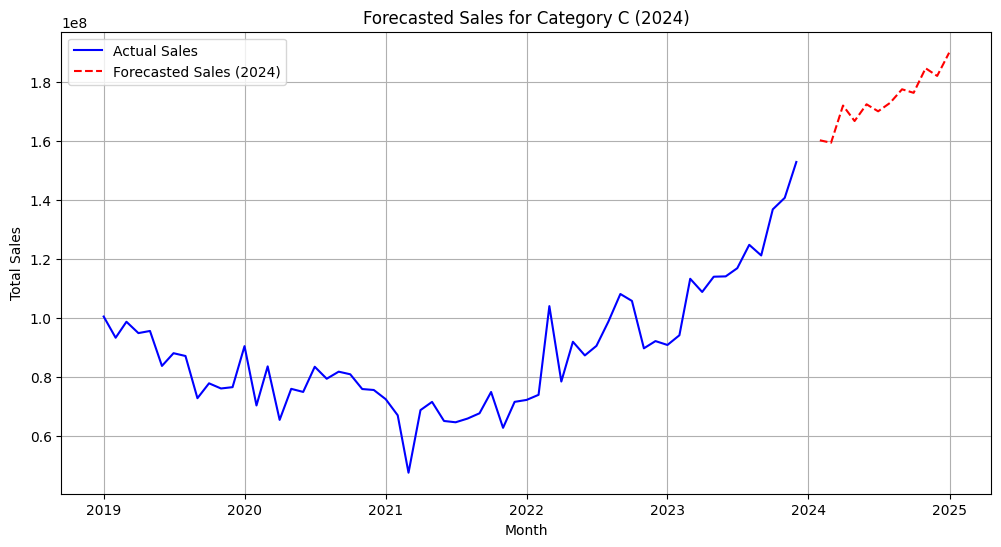

In [ ]:
# Построение графика прогноза продаж для категории C на 2024 год
plt.figure(figsize=(12, 6))

# Оригинальные данные
plt.plot(abc_monthly_sales.index, abc_monthly_sales['C'], label='Actual Sales', color='blue')

# Прогноз
forecast_dates_C = pd.date_range(start=abc_monthly_sales.index[-1], periods=13, freq='M')[1:]
plt.plot(forecast_dates_C, forecast_C, label='Forecasted Sales (2024)', color='red', linestyle='--')

plt.title('Forecasted Sales for Category C (2024)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

# Создание признаков для моделей машинного обучения (линейная регрессия, случайный лес, градиентный бустинг)
# Генерация лагов продаж (здесь используем 12 месяцев как лаг)
for lag in range(1, 13):
    abc_monthly_sales[f'lag_{lag}'] = abc_monthly_sales['A'].shift(lag)

# Удаление первых 12 строк с NaN из-за сдвига
ml_data = abc_monthly_sales.dropna()

# Целевая переменная
y = ml_data['A']

# Признаки
X = ml_data[[f'lag_{lag}' for lag in range(1, 13)]]

# Разделение данных на обучающую и тестовую выборки (последние 12 месяцев как тест)
train_X = X[:-12]
test_X = X[-12:]
train_y = y[:-12]
test_y = y[-12:]

train_X.shape, test_X.shape, train_y.shape, test_y.shape


((36, 12), (12, 12), (36,), (12,))